In [2]:
import pandas as pd 
import numpy as np 
import uncertainties
from uncertainties import ufloat_fromstr
from uncertainties import unumpy as unp
import glob
import matplotlib.pyplot as plt
from scipy import stats
from scipy . optimize import curve_fit
from scipy . interpolate import interp1d
from scipy import optimize
import re

#--- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30

In [3]:

# --- data import --- 

# --- importing copper raw data --- 
data_main_CU = glob.glob('Temp+Force_Cu_*.csv')
print(np.shape(data_main_CU))

# --- importing Aluminium raw data --- 
data_main_Al = glob.glob('Temp+Force_Al_*.csv')
print(np.shape(data_main_Al))

# --- importing calibration data --- 
data_main_calibration = glob.glob('CalibrationPoint*.csv')
print(np.shape(data_main_calibration))

# ---- importing mass calibration data --- 
mass_calibration_data = pd.read_csv('CalibrationMassData.csv', sep = ';', delimiter = None,)

(10,)
(10,)
(4,)


In [4]:
# --- Test Import --- 

test_import = pd.read_csv(data_main_CU[0], sep = ';', delimiter = None,)

test_import

,Time (secs),Force sensor voltage (volts),Force sensor voltage error (volts),Diode circuit voltage (volts),Diode circuit voltage error (volts)
0,0.0,0.562,0.00481,0.776,0.001290
1,1.0,0.563,0.00173,0.775,0.001340
2,2.0,0.564,0.00168,0.774,0.001480
3,3.0,0.563,0.00131,0.774,0.001770
4,4.0,0.563,0.00134,0.774,0.001430
...,...,...,...,...,...
236,236.0,0.519,0.00166,1.000,0.001040
237,237.0,0.519,0.00152,1.000,0.001230
238,238.0,0.519,0.00152,1.000,0.001130
239,239.0,0.519,0.00157,1.000,0.000979


In [5]:
# --- defining an import function --- 

def import_raw(file): 
    t = []; force_V = []; Diode_V = [] # - defining empty arrays. 

    temp = int(re.search(r'\-?\d+', file).group(0)) + 273.15
    file = pd.read_csv(file, sep = ';', delimiter = None,)

    t = file['Time (secs)']
    force_V = unp.uarray(file['Force sensor voltage (volts)'], file['Force sensor voltage error (volts)'])
    Diode_V = unp.uarray(file['Diode circuit voltage (volts)'], file['Diode circuit voltage error (volts)'])


    return np.array(t), force_V, Diode_V, temp 

def temp(filename):
    return int(re.search(r'\-?\d+', filename).group(0)) + 273.15

In [6]:
def lin_func(x, m, c):
    return m*x + c #equation of a line y = mx + c

In [7]:
# --- array definition --- 

mass = unp.uarray(mass_calibration_data['Mass (Kg)'], mass_calibration_data['Mass Error (Kg)'])
voltage = unp.uarray(mass_calibration_data['Force Sensor Voltage (Volts)'], mass_calibration_data['Force Sensor Voltage Error (Volts)'])

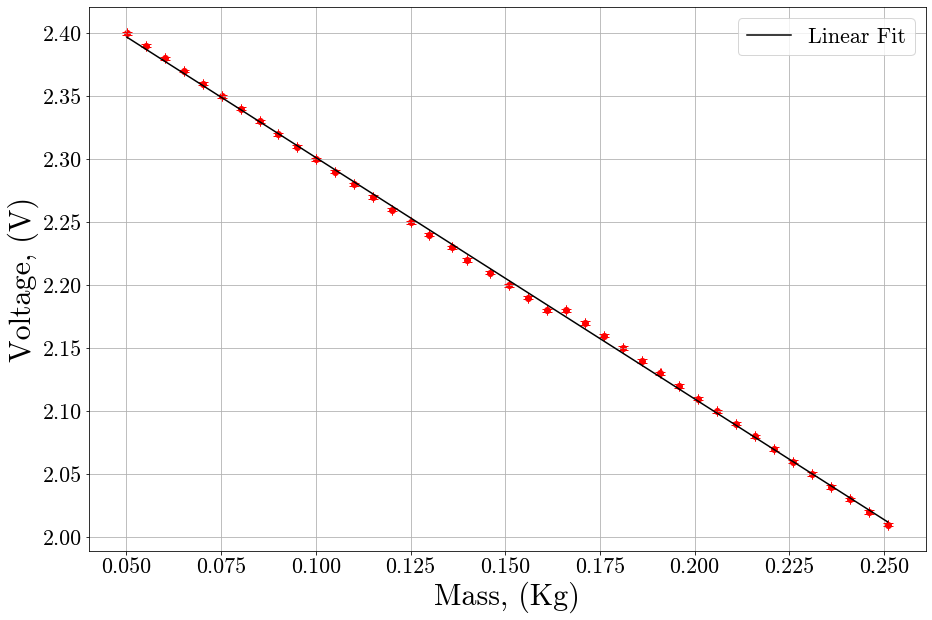

In [8]:
# --- data definition --- 

x = unp.nominal_values(mass)
xerr = unp.std_devs(mass)

y = unp.nominal_values(voltage)
yerr = unp.std_devs(voltage)

x_fit = np.linspace(0, x.max(), 10)

# --- fitting data for graph --- 

popt1, pcov1 = curve_fit(lin_func, x, y, sigma = (xerr))
fit_data = lin_func(x, popt1[0], popt1[1])

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = xerr, yerr = yerr, capsize= 5, ls='none', color = 'red')
plt.plot(x, fit_data, 'black', label = 'Linear Fit')


plt.grid()
plt.xlabel('Mass, (Kg)')
plt.ylabel('Voltage, (V)')
plt.legend()

In [9]:
print('The equation of the above fit is: y = ', "{:.3f}".format(popt1[0]), 'x +', "{:.3f}".format(popt1[1]))

# --- finding y-intercept --- 

x = 0 
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

# --- uncertainties on the slopes --- 

print('Uncertainty on the slope was found to be: ' "{:.3f}".format(np.sqrt(pcov1[1][1])))

The equation of the above fit is: y =  -1.916 x + 2.493
y-intercept of the line: 2.493
Uncertainty on the slope was found to be: 0.001


In [10]:
def mass_func(V): 
    return -0.52192066*V + 1.30114822

In [11]:
def heat_capacity_exp(dM, T, L, n):# 1 - kJ/mol 2 - Number of moles 
    return (L*dM)/(n*(T - 77))

In [12]:
def import_calibration(file): 
    temp = []; Diode_V = [] # - defining empty arrays. 

    file = pd.read_csv(file, sep = ';', delimiter = None,)

    temp = unp.uarray(file['Temperature (K)'], file['Temp Error (K)'])
    Diode_V = unp.uarray(file['Diode Circuit Voltage (Volts)'], file['Diode Volt Error (Volts)'])

    return temp, Diode_V


In [13]:
import_calibration(data_main_calibration[0])[1]

array([1.0+/-0.000847], dtype=object)

<ipython-input-14-d5bbab7fb62f>:32: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-14-d5bbab7fb62f>:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-14-d5bbab7fb62f>:37: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

Text(0, 0.5, 'Mass (g)')

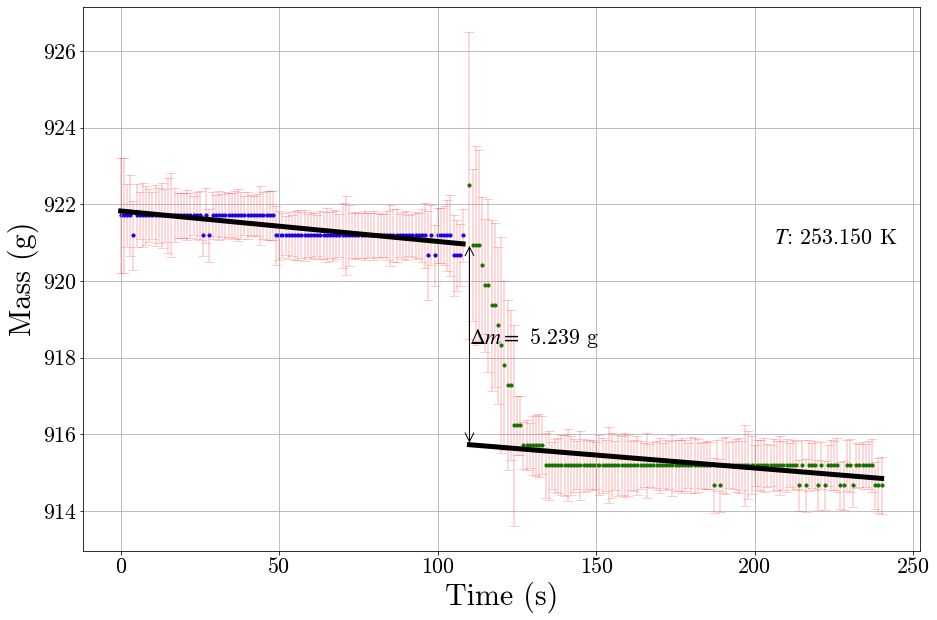

In [14]:
# --- Al at 15C --- 

data = import_raw(data_main_Al[5])
mass = mass_func(data[1])

# --- Splitting both sets --- 

split1 = np.argmax(np.diff(unp.nominal_values(mass*1000)))
split2 = split1 + 1  

# --- Split One --- 

plt.scatter(data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], s = 10, color = 'blue')
plt.errorbar(data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], xerr = None, yerr = (unp.std_devs(mass)*1000)[0:split1], capsize= 5, ls='none', color = 'red', alpha = .2)

popt1, pcov1 = curve_fit(lin_func, data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], sigma = ((unp.std_devs(mass)*1000)[0:split1]))
fit_data1 = lin_func(data[0][0:split1], popt1[0], popt1[1])

plt.plot(data[0][0:split1], fit_data1, 'black', label = 'Linear Fit', linewidth = 5.0)


# --- Split Two --- 

plt.scatter(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], s = 10, color = 'green')
plt.errorbar(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], xerr = None, yerr = (unp.std_devs(mass)*1000)[split2:len(mass)], capsize= 5, ls='none', color = 'red', alpha = .2)

popt2, pcov2 = curve_fit(lin_func, data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 11.22)[split2:len(mass)], sigma = ((unp.std_devs(mass)*1000)[split2:len(mass)]))
fit_data2 = lin_func(data[0][split2:len(mass)], popt2[0], popt2[1])

plt.plot(data[0][split2:len(mass)], fit_data2, 'black', linewidth = 5.0)

plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))

deltam = fit_data1[-1] -  fit_data2[0]

plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam)))

plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Mass (g)')

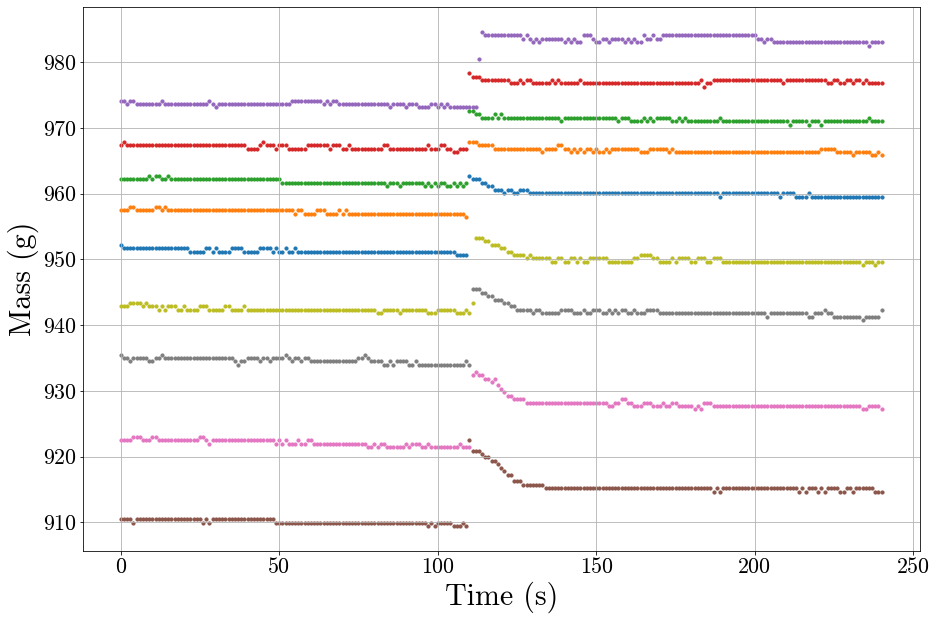

In [15]:
for i in range(0, 9): 

    data = import_raw(data_main_Al[i])

    mass = mass_func(data[1])

    plt.scatter(data[0], unp.nominal_values(mass)*1000 - 11.22, s = 10, label = '')
    # plt.errorbar(data[0], unp.nominal_values(mass)*1000 - 11.22, xerr = None, yerr = unp.std_devs(mass)*1000, capsize= 5, ls='none', color = 'red', alpha = .5)

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (g)')

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

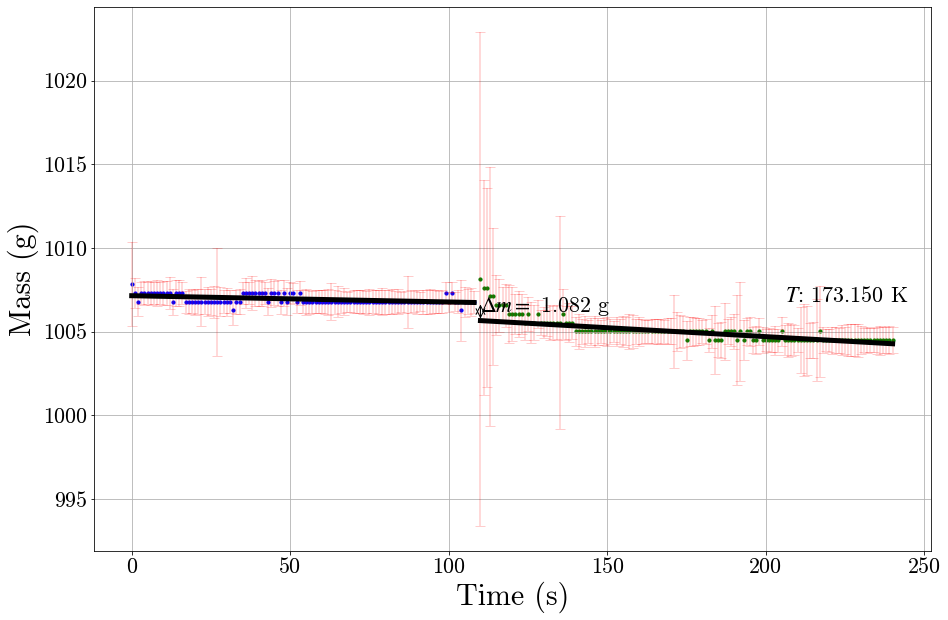

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

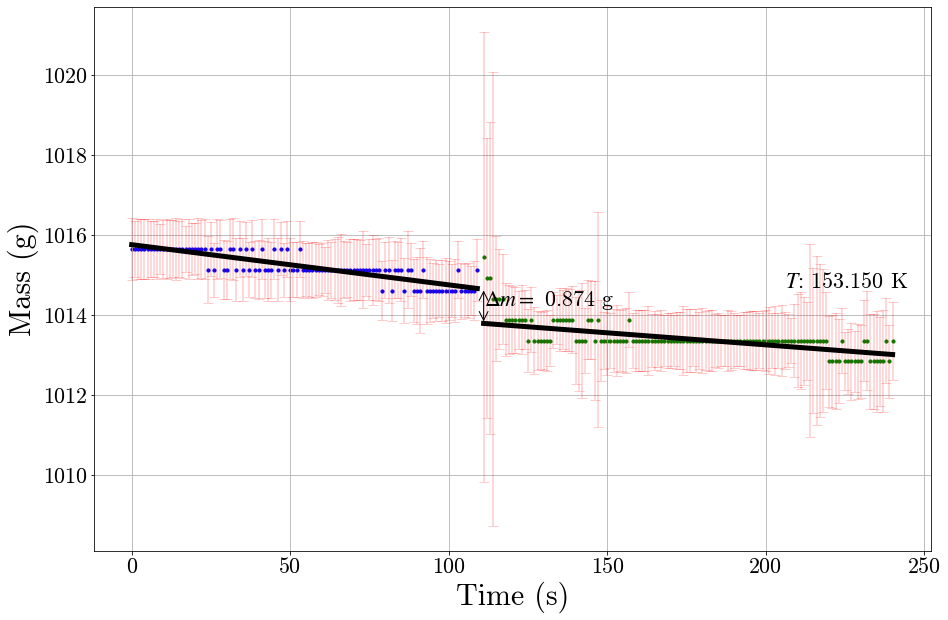

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

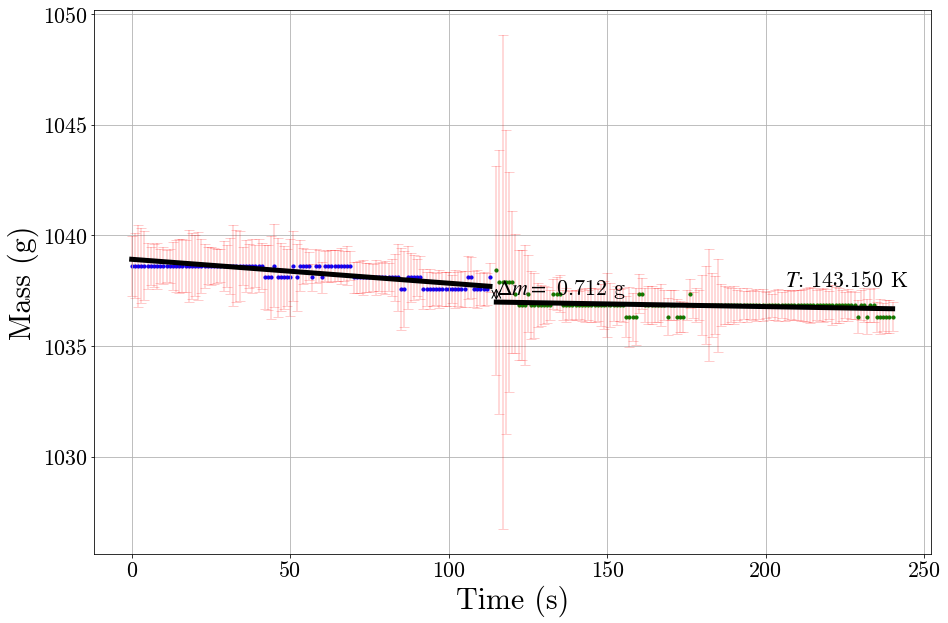

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

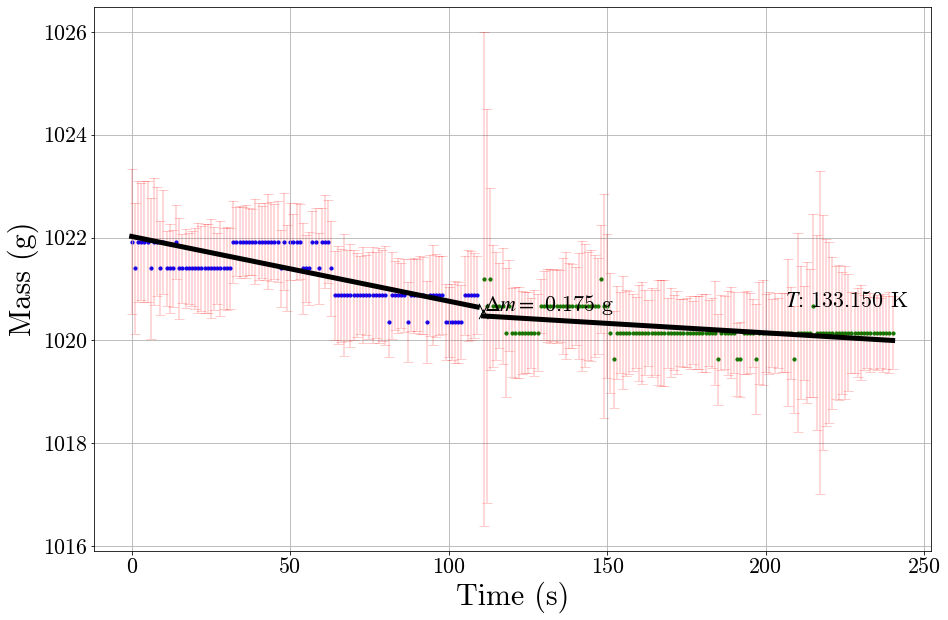

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

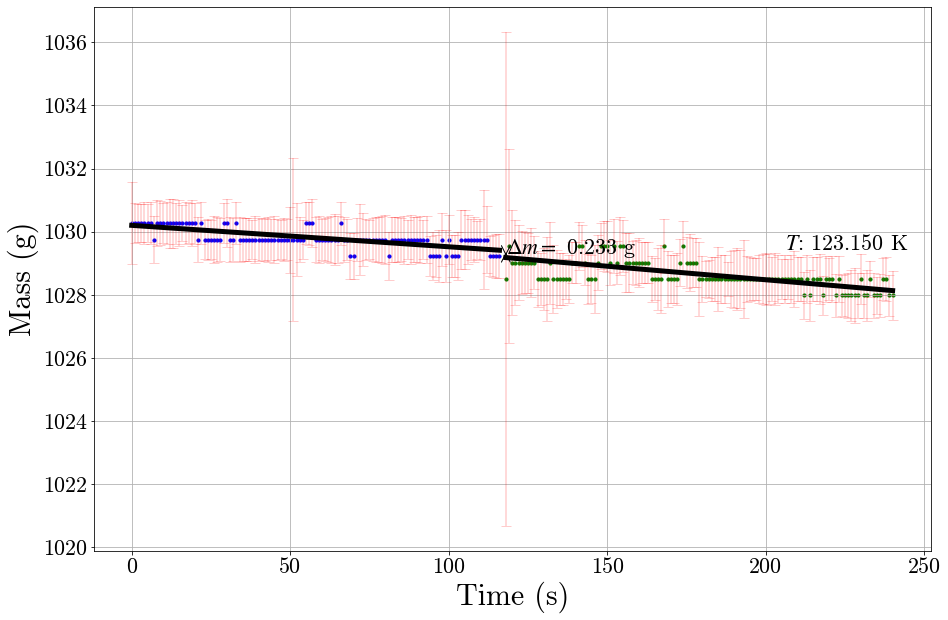

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

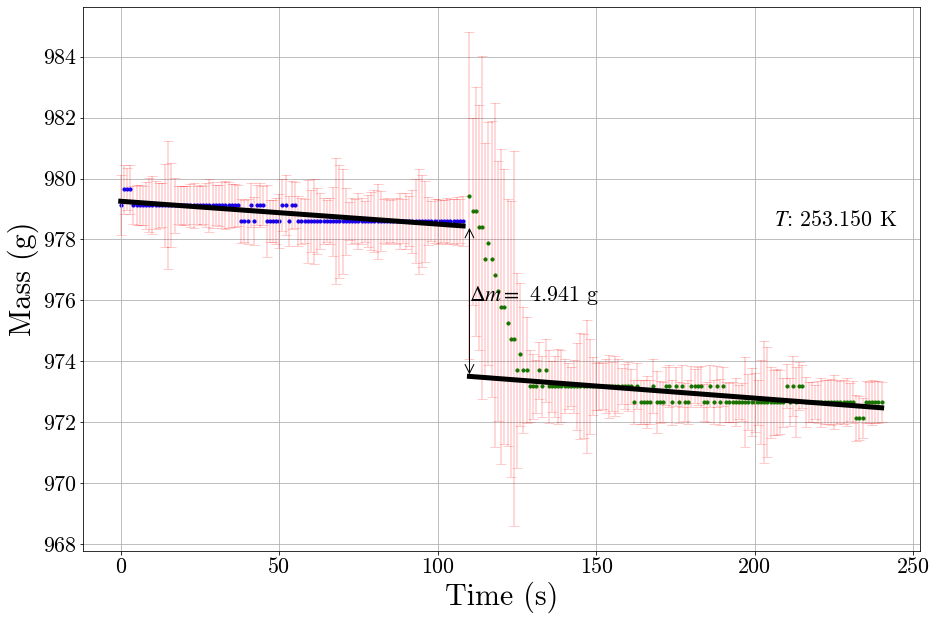

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

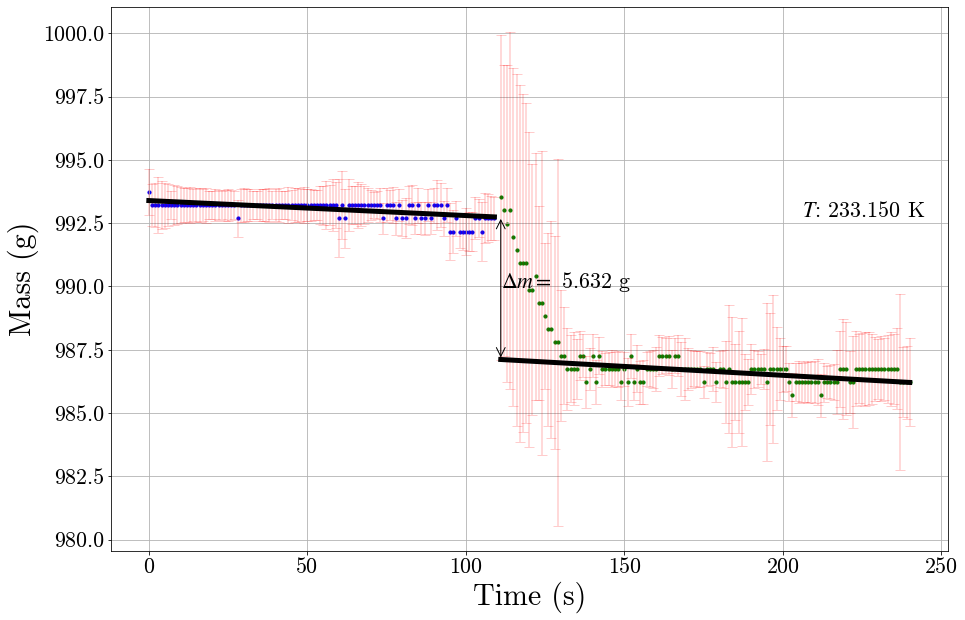

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

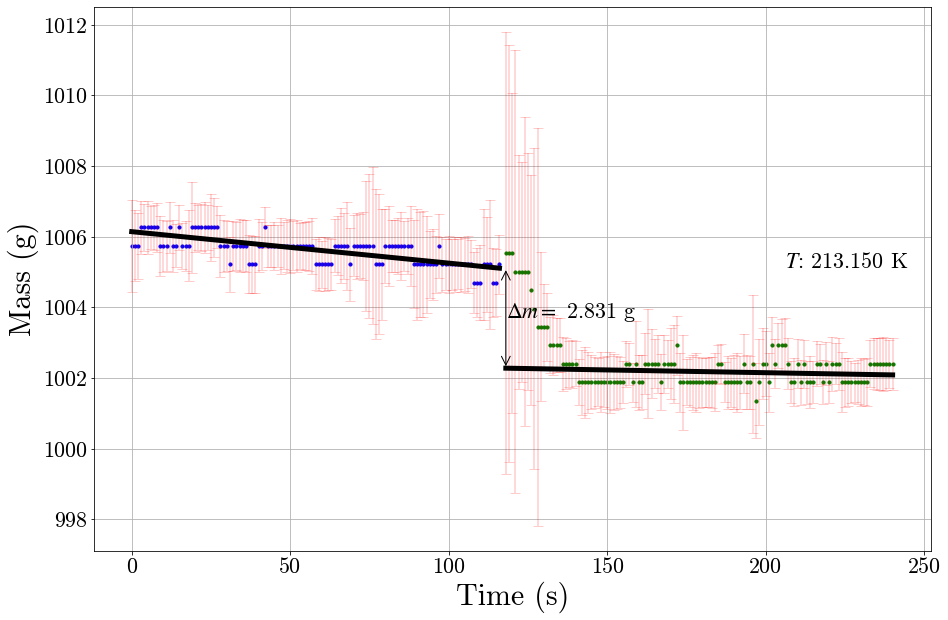

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

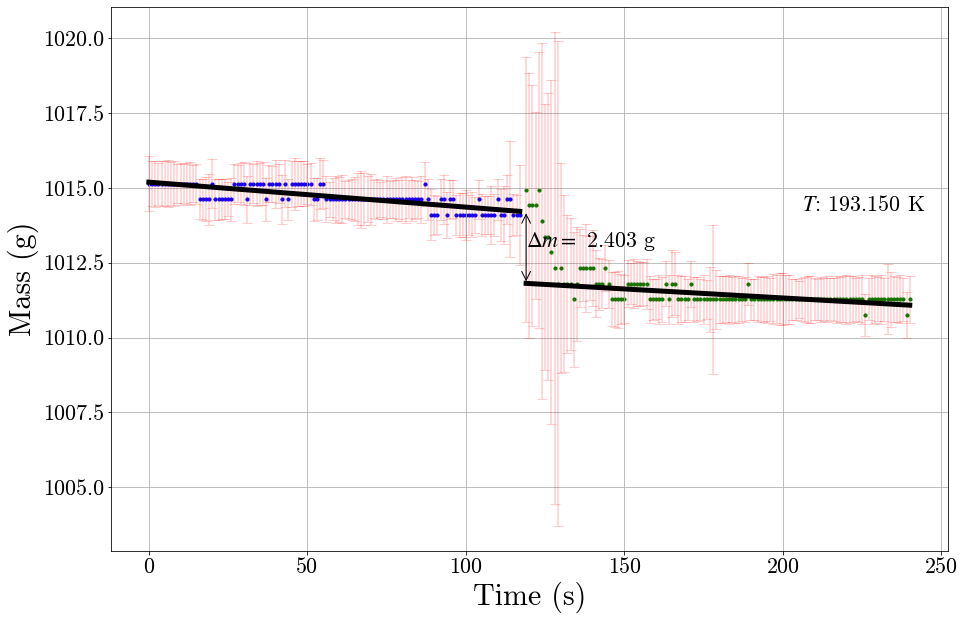

<ipython-input-18-4fa83e123116>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))
<ipython-input-18-4fa83e123116>:47: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
<ipython-input-18-4fa83e123116>:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam))

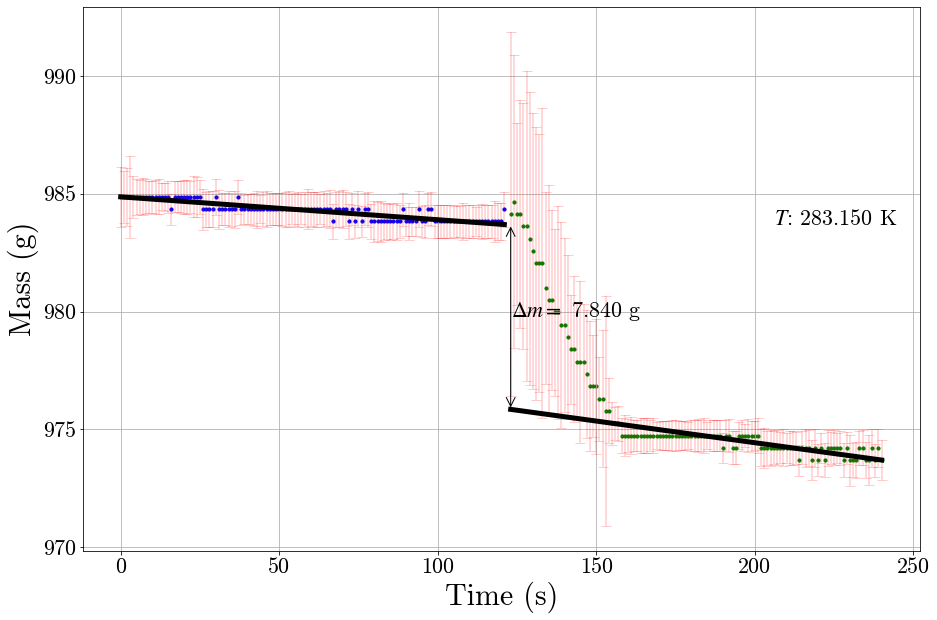

In [18]:
al_Cv_exp = []; al_Cv_ein = []; temp = [] ; m = []

for i in range(0, 10): 

    data = import_raw(data_main_CU[i])

    mass = mass_func(data[1])

    # --- Splitting both sets --- 

    split1 = np.argmax(np.diff(unp.nominal_values(mass*1000)))
    split2 = split1 + 1  

    # --- Split One --- 
    #eliminated the -25.78
    plt.scatter(data[0][0:split1], (unp.nominal_values(mass)*1000 )[0:split1], s = 10, color = 'blue')
    plt.errorbar(data[0][0:split1], (unp.nominal_values(mass)*1000)[0:split1], xerr = None, yerr = (unp.std_devs(mass)*1000)[0:split1], capsize= 5, ls='none', color = 'red', alpha = .2)
    #again, eliminated -25.78
    popt1, pcov1 = curve_fit(lin_func, data[0][0:split1], (unp.nominal_values(mass)*1000)[0:split1], sigma = ((unp.std_devs(mass)*1000)[0:split1]))
    fit_data1 = lin_func(data[0][0:split1], popt1[0], popt1[1])

    plt.plot(data[0][0:split1], fit_data1, 'black', label = 'Linear Fit', linewidth = 5.0)


    # --- Split Two --- 

    plt.scatter(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 25.78)[split2:len(mass)], s = 10, color = 'green')
    plt.errorbar(data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 25.78)[split2:len(mass)], xerr = None, yerr = (unp.std_devs(mass)*1000)[split2:len(mass)], capsize= 5, ls='none', color = 'red', alpha = .2)

    popt2, pcov2 = curve_fit(lin_func, data[0][split2:len(mass)], (unp.nominal_values(mass)*1000 - 25.78)[split2:len(mass)], sigma = ((unp.std_devs(mass)*1000)[split2:len(mass)]))
    fit_data2 = lin_func(data[0][split2:len(mass)], popt2[0], popt2[1])

    plt.plot(data[0][split2:len(mass)], fit_data2, 'black', linewidth = 5.0)

    plt.annotate(s='', xy = (data[0][split2:len(mass)][0], fit_data2[0]), xytext=(data[0][split2], fit_data1[-1]), arrowprops=dict(arrowstyle='<->'))

    # --- Experimental Calculations 

    deltam = np.abs(fit_data1[-1] -  fit_data2[0])
    m.append(deltam)

    al_Cv_exp.append(heat_capacity_exp(deltam, data[3], 197.5, 0.4158399))

    temp.append(data[3])
    

    plt.annotate(s='$\Delta m =$ %s g' % '{:.3f}'.format(deltam), xy = (data[0][split2],  (fit_data2[0] + .5*deltam)))
    plt.annotate(s='$T$: %s K' % '{:.3f}'.format(data[3]), xy = (data[0][-35],  (fit_data2[0] + deltam)))

    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Mass (g)')

    
    plt.show()

[1.8027954172193859, 1.0365717741079834, 0.8177349835211771, 1.131224327695577, 0.8082889750895674, 5.238705232412485, 3.9652798168442587, 2.8495761853125714, 2.7536083609559228, 7.5457803357450075]


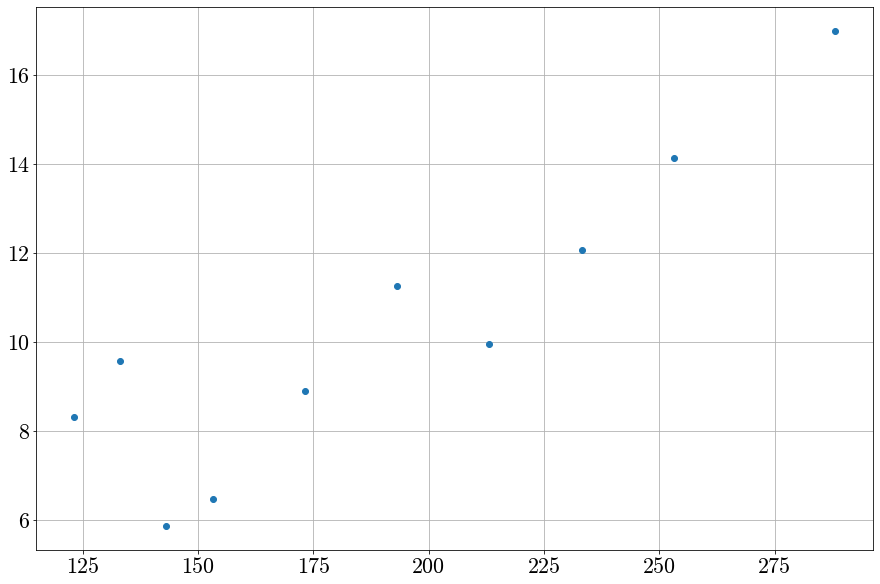

In [17]:
plt.plot(temp, al_Cv_exp, 'o')
plt.grid()
print(m)